In [1]:
import pandas as pd 
from sklearn.utils import shuffle
import utils as ut 
from sklearn.model_selection import train_test_split

from sklearn.ensemble import  VotingClassifier
import numpy as np 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

%matplotlib inline 


We do the analysis in the following steps. 
- [Load data](#sec1)
- [Plot](#sec2)
- [Data prep](#sec3)
- [Benchmark](#sec4)
- [Compare classifiers while applying cross-validation and oversampling with SMOTE](#sec5)
- [Ensemble](#sec6)
- [Hyperparameter tuning (TBD)](#sec7)

## 1. Load data 
<a id='sec1'></a>

In [2]:
df = pd.read_csv('./dataset_31_credit-g.csv')
df = shuffle(df)

df.head(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
226,'0<=X<200',48,'existing paid',radio/tv,10961,'>=1000','4<=X<7',1,'male single','co applicant',...,'no known property',27,bank,own,2,skilled,1,yes,yes,bad
669,'>=200',30,'critical/other existing credit',radio/tv,3017,'<100','>=7',4,'male single',none,...,'life insurance',47,none,own,1,skilled,1,none,yes,good
996,'<0',30,'existing paid','used car',3857,'<100','1<=X<4',4,'male div/sep',none,...,'life insurance',40,none,own,1,'high qualif/self emp/mgmt',1,yes,yes,good
144,'no checking',21,'critical/other existing credit',furniture/equipment,2288,'<100','<1',4,'female div/dep/mar',none,...,'life insurance',23,none,own,1,skilled,1,yes,yes,good
528,'<0',36,'existing paid',radio/tv,2302,'<100','1<=X<4',4,'male div/sep',none,...,car,31,none,rent,1,skilled,1,none,yes,bad
218,'<0',24,'existing paid',furniture/equipment,3021,'<100','1<=X<4',2,'male div/sep',none,...,'real estate',24,none,rent,1,'unskilled resident',1,none,yes,good
84,'<0',10,'existing paid',radio/tv,2315,'<100','>=7',3,'male single',none,...,'real estate',52,none,own,1,'unskilled resident',1,none,yes,good
136,'no checking',27,'delayed previously','used car',8613,'>=1000','1<=X<4',2,'male single',none,...,car,27,none,own,2,skilled,1,none,yes,good
610,'<0',12,'existing paid','domestic appliance',741,'100<=X<500',unemployed,4,'female div/dep/mar',none,...,'life insurance',22,none,own,1,skilled,1,none,yes,bad
47,'<0',6,'existing paid','used car',1352,'500<=X<1000',unemployed,1,'female div/dep/mar',none,...,'life insurance',23,none,rent,1,'unemp/unskilled non res',1,yes,yes,good


## 2. Plot

<a id='sec2'></a>

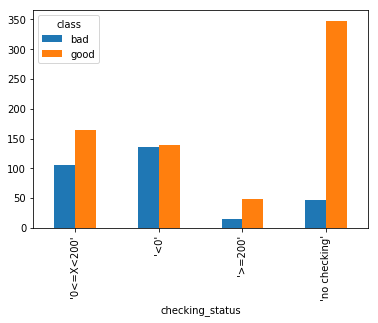

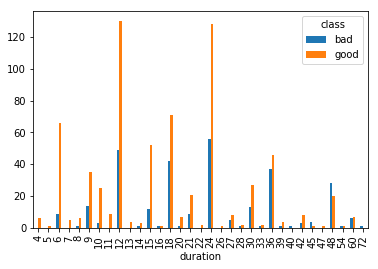

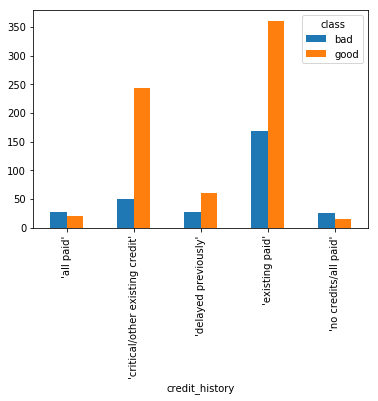

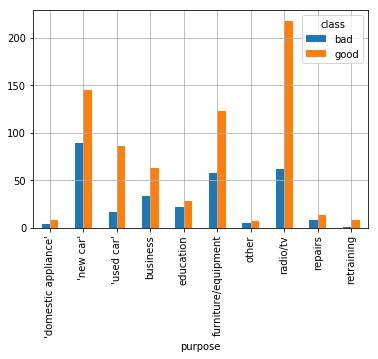

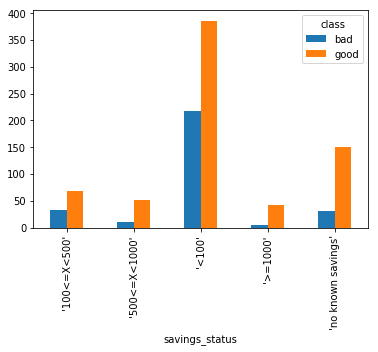

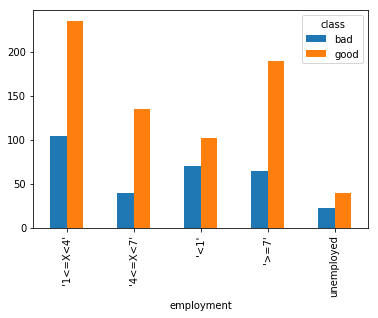

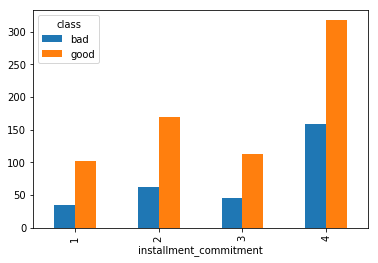

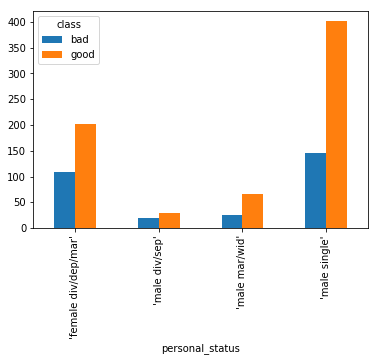

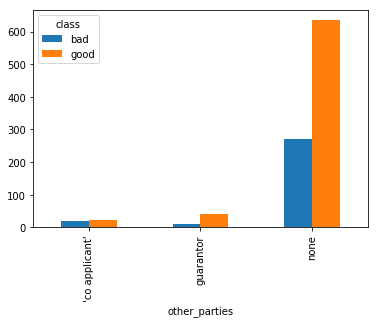

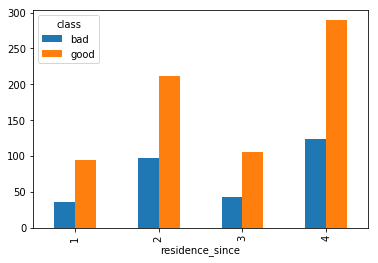

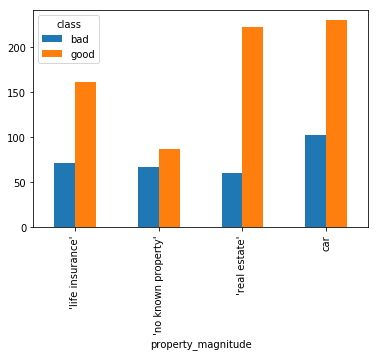

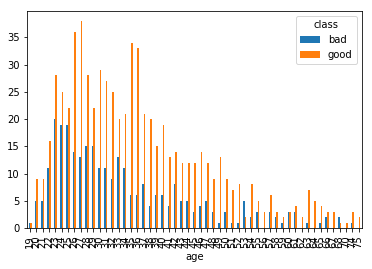

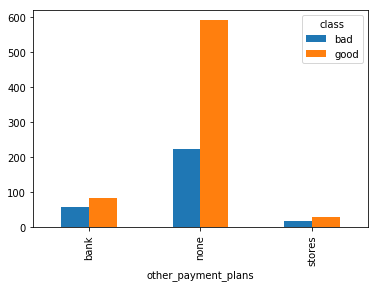

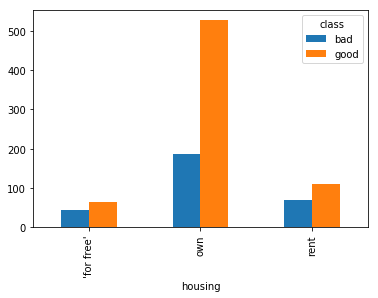

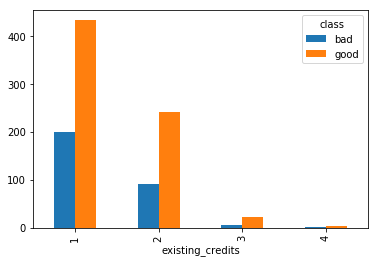

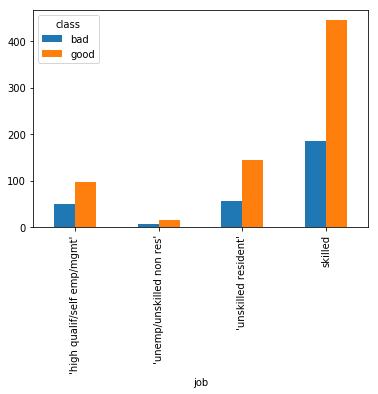

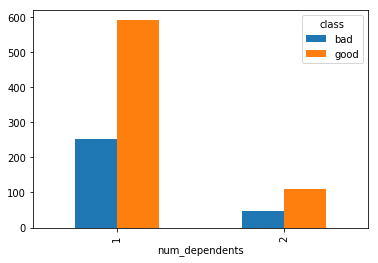

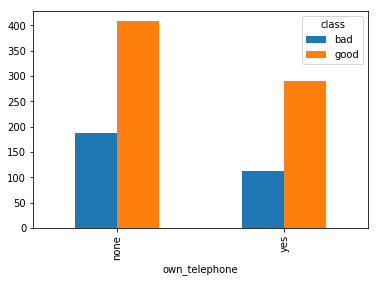

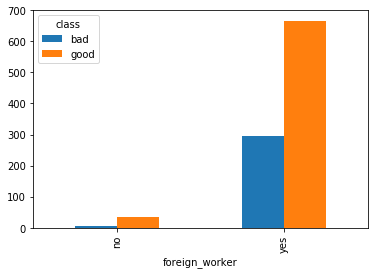

In [40]:
## plotting data 
ut.plot_df(df)

- Classification problem 
- Imbalanced classes - 700 vs 300 
    - can be handled with oversampling or undersampling - in the case of oversampling, be careful with K fold cross validation, see below.

## 3: Data prep
<a id='sec3'></a>

In [3]:
df = ut.label_encode(df)
x0 = df.drop(['class'], axis=1)
y0 = df['class']
x_train, x_test, y_train, y_test = train_test_split(x0, y0, test_size=0.20, random_state=42, shuffle=True)

 test <a id="section_ID"></a>

## 4. Note about oversampling, k-fold cross validation, and benchmarking
<a id='sec4'></a>

We have to be careful before using 5-fold cross validation, because if we oversample and then perform the 5-fold cross validation then we will get artificially high accuracies. 
The workaround to this : 

- Inside the cross-validation loop, get a sample out and do not use it for anything 
- Oversample the minority class in the remaining data and use it together with majority to create and fit model
- Repeat k times for k-fold cross validation, where n is your number of samples (if doing leave one participant out cross-validation).

The baseline precision is 70\% because thats what we'll get if we guess True across the board. Similarly, the cost function for this case is 1.45. 


## 5. Comparing models and cross-validation
<a id='sec5'></a>

In [5]:
names, classifiers, allscores_precision, allscores_cust = ut.run_classifiers(x_train, y_train)

In [6]:
ap = np.array(allscores_precision).flatten().reshape(9,10)
ac = np.array(allscores_cust).flatten().reshape(9,10)

apm = np.mean(ap, axis=0)
aps = np.std(ap, axis=0)

acm = np.mean(ac, axis=0)
acs = np.std(ac, axis=0)

> It seems that oversampling, either through SMOTE or the simplest way makes the most difference, as expected. I expect SMOTE will generalize better, so let's continue using it. 

In [7]:
for i in range(10): 
    print(names[i],  "\t Precision = %.2f (+/- %.2f), cost = %.2f (+/- %.2f) " % (apm[i], aps[i], acm[i], acs[i]))

Nearest Neighbors 	 Precision = 0.74 (+/- 0.06), cost = 1.02 (+/- 0.15) 
Gaussian Process 	 Precision = 0.76 (+/- 0.08), cost = 1.05 (+/- 0.28) 
Decision Tree 	 Precision = 0.84 (+/- 0.09), cost = 0.71 (+/- 0.26) 
Random Forest 	 Precision = 0.82 (+/- 0.05), cost = 0.77 (+/- 0.16) 
GradientBoosting 	 Precision = 0.81 (+/- 0.05), cost = 0.79 (+/- 0.15) 
Neural Net 	 Precision = 0.78 (+/- 0.09), cost = 1.01 (+/- 0.39) 
AdaBoost 	 Precision = 0.83 (+/- 0.05), cost = 0.71 (+/- 0.15) 
Naive Bayes 	 Precision = 0.82 (+/- 0.06), cost = 0.76 (+/- 0.19) 
QDA 	 Precision = 0.80 (+/- 0.06), cost = 0.84 (+/- 0.20) 
XGB 	 Precision = 0.81 (+/- 0.05), cost = 0.79 (+/- 0.14) 


## 6. Ensembling 
<a id='sec6'></a>

In [9]:
arr = []
for i in range(10):
    dt= (names[i], classifiers[i])
    arr.append(dt)

In [16]:
eclf = VotingClassifier(estimators=arr,
                         voting='soft')

In [17]:
eclf.fit(x_train, y_train)

VotingClassifier(estimators=[('Nearest Neighbors', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')), ('Gaussian Process', GaussianProcessClassifier(copy_X_train=True,
             kernel=1**2 * RBF(...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [18]:
y_pred = eclf.predict(x_test)
precision = precision_score(y_test, y_pred)
loss = ut.cost_loss_func(y_pred=y_pred, y_true=y_test)
print(precision)
print(loss)

0.810126582278481
0.825


Confusion matrix, without normalization
[[ 27  30]
 [ 15 128]]


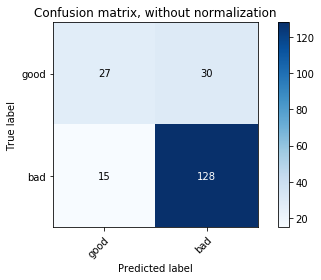

In [20]:
ut.confusion_matrix(y_pred=y_pred,y_true=y_test)
ut.plot_confusion_matrix(classes=['good', 'bad'],normalize=False,title=None,y_pred=y_pred,y_true=y_test)

## 7. Hyper-parameter tuning (TBD)

<a id='sec7'></a>